In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)

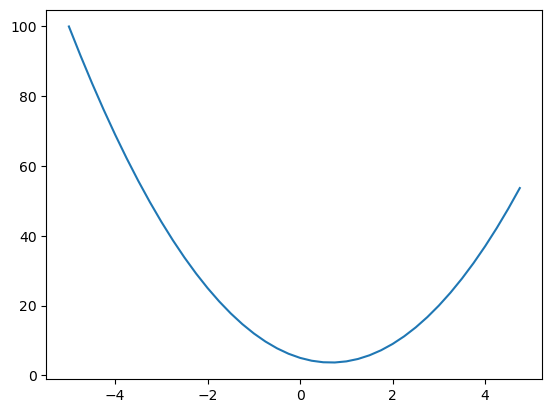

In [5]:
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.001
x = 2/3
print((f(x+h) - f(x))/h)

0.0029999999995311555


In [7]:
#Now, we have more complex variable equations:
h = 0.0001

#fixed inputs:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
print('d1:', d1)

a += h
d2 = a*b + c
print('d2:', d2)

print('slope:', (d2 - d1)/h)

d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [8]:
class Value:

    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data =  data
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other): # other + self
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        #first build the topological graph starting at itself
        sorted = []
        visited = set()
        def toposort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    toposort(child)
                sorted.append(v)
        toposort(self)

        #now, we can set the first gradient to 1:
        self.grad = 1.0
        for node in reversed(sorted):
            node._backward()
        

In [9]:
from graphviz import Digraph

#takes all the values starting from the root and passes them into the nodes set
#takes each of the edges between nodes and adds them to the edges set
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

#graphviz drawing code:
def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if  n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [10]:
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1, w2, bias b
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

#values
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

#raw activation value
n = x1w1x2w2 + b; n.label = 'n'

#activation value after function
output = n.tanh()

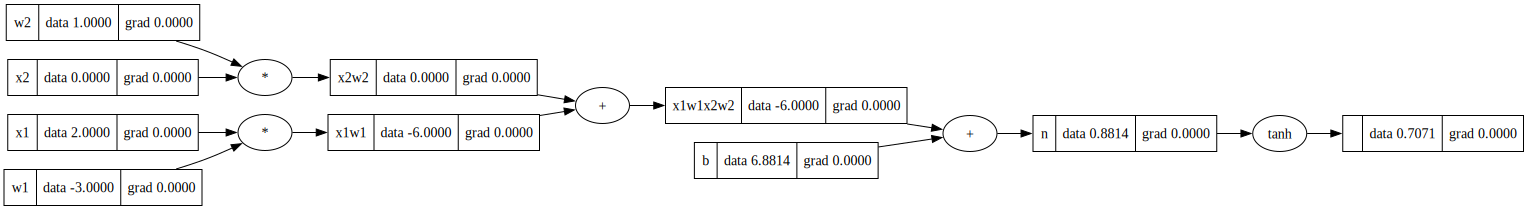

In [11]:
draw_dot(output)

In [12]:
#manual backpropagation for the neuron:
# output.grad = 1.0 

# #since output = tanh(x), do/dn = 1 - tanh^2(x)
# n.grad = 1 - output.data**2
# x1w1x2w2.grad = n.grad
# b.grad = 0.5

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# x1.grad = x1w1.grad*w1.data
# w1.grad = x1w1.grad*x1.data
# x2.grad = x2w2.grad*w2.data
# w2.grad = x2w2.grad*x2.data

In [13]:
#instead of manual calls, we will call _backward in the right order:
#base case, since out.grad is defaulted to zero
# output.grad = 1.0

#backpropagate the derivative backward in the correct order
# output._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [14]:
#Now, the only thing we need to do is to automatically call backpropogate
#We can do this through a topological sort:
#WE WILL INSERT THIS INTO THE VALUE CLASS
# sorted = []
# visited = set()

# def toposort(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             toposort(child)
#         sorted.append(v)

# toposort(output)

In [15]:
#now, with our method, we can iterate backward through the sorted array and call backward:
output.backward()

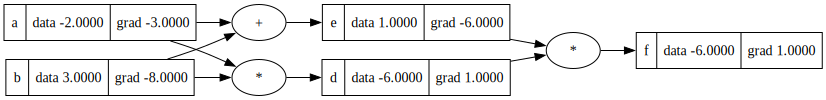

In [16]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

In [17]:
#Base Module class that provides zero_grad functionality:

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    
    def parameters(self):
        return []



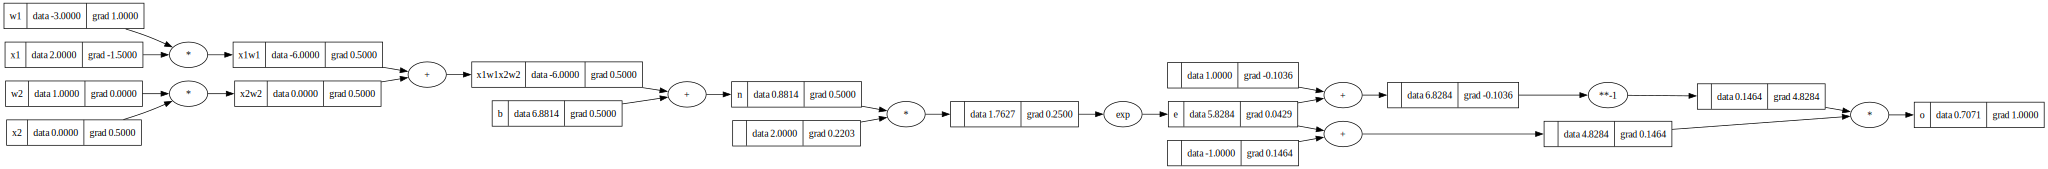

In [18]:
#Here we have broken tanh into its exponential and division parts:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1, w2, bias b
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')

#values
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

#raw activation value
n = x1w1x2w2 + b; n.label = 'n'

#activation value after function
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [19]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [20]:
#Now we will make some neural networks with pytorch
class Module:
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

class Neuron(Module):
    
    def __init__(self, num):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        total = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #Sum adds all the wi*xi, starting with value self.b
        out = total.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [21]:
#We will now define a LAYER of neurons:

class Layer(Module):

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        #identical to:
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)


In [22]:
#We can create a multi-layered perceptron now (MLP):

class MLP(Module):

    #nins is the number of initial inputs, while nouts is a list of the number of outputs, aka the nubmer of neurons per layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) #calls each layer sequentially, starting with the original input layer x. The output of each layer is the input
        return x         #of the next layer, so you can do these self-setting calls, x = layer(x)

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
#MLP creates layers with the specified number of initial inputs. It sets future inputs to be the output of the previous layer, allowing
#for the entire neural network to propagate forward. Each layer creates nout neurons, where nout is the number of outputs, each of which
#takes nin inputs, the number of inputs.

In [23]:
n = MLP(3, [4,4,1])
#simple example dataset:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets


In [24]:
alpha = 0.05
for k in range(40):
    
    #forward pass:
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass (setting gradient to zero before backward pass):
    n.zero_grad()
    loss.backward()

    #update (gradient descent):
    for p in n.parameters():
        #update each parameter by the gradient by a small rate (alpha)
        p.data += -(alpha * p.grad)

    print(k+1, loss.data)

1 5.190650979402626
2 3.852629549678838
3 2.62552569748164
4 0.958121188584444
5 0.40808558671239525
6 0.24895473310062063
7 0.17703220485234117
8 0.1365942449310616
9 0.1108348939999894
10 0.09305175167423377
11 0.08006664806658981
12 0.0701846386385967
13 0.062421484665370654
14 0.05616751137087992
15 0.051025403517033885
16 0.046725413760667994
17 0.043078115649289636
18 0.03994666607505043
19 0.03722979693810771
20 0.03485099425065856
21 0.032751392494528624
22 0.030884978741030904
23 0.029215276882184282
24 0.027713005901742926
25 0.026354394438109795
26 0.025119946946589908
27 0.023993526536633666
28 0.02296166369200545
29 0.022013028626707315
30 0.021138023868815844
31 0.020328466328735195
32 0.01957733676596879
33 0.018878580579030472
34 0.018226948075643574
35 0.017617865400277967
36 0.01704732947719642
37 0.016511821920430728
38 0.01600823803830294
39 0.015533827937019955
40 0.015086147387735853


In [25]:
print("Predictions: ")
print(ypred)

Predictions: 
[Value(data=0.9698643938304621), Value(data=-0.9110756625607821), Value(data=-0.955123146680318), Value(data=0.9347579669564918)]
